## Classificação de Risco das Ações da B3

Este notebook realiza:
1. Extração de dados das ações da B3 via yfinance
2. Cálculo de métricas de risco (volatilidade, drawdown, beta, liquidez)
3. Classificação das ações em 5 níveis de risco
4. Exportação dos dados para integração com o backend

## Importação de Bibliotecas

In [6]:
import os
import ssl
import certifi
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')  # Ignorar avisos

# Configurar certificados SSL (necessário para algumas conexões)
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context


## Configuração do Ambiente

In [10]:
# Configurar diretório de dados
data_dir = "C:\stock-advisor-backend\data"
if not os.path.exists(data_dir):
    print(f"Criando diretório {data_dir}")
    os.makedirs(data_dir)
else:
    print(f"Diretório de dados encontrado: {data_dir}")

# Configurar visualizações
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Mostrar o diretório onde os dados serão salvos
print(f"Os arquivos serão salvos em: {data_dir}")
print("Configuração inicial concluída com sucesso!")


Diretório de dados encontrado: C:\stock-advisor-backend\data
Os arquivos serão salvos em: C:\stock-advisor-backend\data
Configuração inicial concluída com sucesso!


## Obtenção da Lista de Tickers da B3

A função abaixo retorna a lista dos tickers mais relevantes da B3 para análise.

In [12]:
def get_b3_tickers(number_of_stocks=50):
    """
    Retorna uma lista com os tickers mais relevantes da B3.
    
    Args:
        number_of_stocks: Número de ações a considerar
        
    Returns:
        Lista de tickers da B3
    """
    print("=" * 50)
    print(">>> INICIANDO: Obtendo lista de tickers da B3")
    print("=" * 50)

    # Lista com os principais tickers da B3
    b3_tickers = [
        'PETR4', 'VALE3', 'ITUB4', 'BBDC4', 'ABEV3', 'B3SA3', 'WEGE3',
        'RENT3', 'BBAS3', 'PETR3', 'ITSA4', 'SUZB3', 'EQTL3', 'RADL3',
        'JBSS3', 'BBSE3', 'SANB11', 'HYPE3', 'UGPA3', 'BRFS3', 'CMIG4',
        'LREN3', 'BBDC3', 'VIVT3', 'MGLU3', 'GGBR4', 'EMBR3', 'RAIL3',
        'CCRO3', 'TOTS3', 'KLBN11', 'CIEL3', 'SULA11', 'ENEV3', 'CSAN3',
        'PCAR3', 'CSNA3', 'FLRY3', 'MRFG3', 'SBSP3', 'AZUL4', 'AMER3',
        'MULT3', 'CYRE3', 'BRML3', 'COGN3', 'BPAC11', 'YDUQ3', 'TAEE11', 'GOAU4'
    ]

    # Limitar ao número solicitado
    result_tickers = b3_tickers[:number_of_stocks]
    
    # Exportar lista de tickers (útil para referência)
    tickers_df = pd.DataFrame(result_tickers, columns=['ticker'])
    tickers_df.to_csv(os.path.join(data_dir, "b3_tickers.csv"), index=False)
    
    print(f"Selecionados {len(result_tickers)} tickers")
    print(f"Primeiros 5: {result_tickers[:5]}")
    print(f"Últimos 5: {result_tickers[-5:]}")
    print("Lista de tickers salva em: " + os.path.join(data_dir, "b3_tickers.csv"))
    print("=" * 50)
    
    return result_tickers

# Obter lista de tickers
tickers = get_b3_tickers(50)

# Exibir primeiros tickers
print("\nPrimeiros 10 tickers:")
for i, ticker in enumerate(tickers[:10], 1):
    print(f"{i}. {ticker}")


>>> INICIANDO: Obtendo lista de tickers da B3
Selecionados 50 tickers
Primeiros 5: ['PETR4', 'VALE3', 'ITUB4', 'BBDC4', 'ABEV3']
Últimos 5: ['COGN3', 'BPAC11', 'YDUQ3', 'TAEE11', 'GOAU4']
Lista de tickers salva em: C:\stock-advisor-backend\data\b3_tickers.csv

Primeiros 10 tickers:
1. PETR4
2. VALE3
3. ITUB4
4. BBDC4
5. ABEV3
6. B3SA3
7. WEGE3
8. RENT3
9. BBAS3
10. PETR3


## Obtenção de Dados Históricos  

A função abaixo obtém dados históricos para cada ticker da lista, utilizando a biblioteca yfinance.

>>> INICIANDO: Obtendo dados históricos para 50 ações
[1/5] Obtendo dados para PETR4... OK (250 dias)
[2/5] Obtendo dados para VALE3... OK (250 dias)
[3/5] Obtendo dados para ITUB4... OK (250 dias)
[4/5] Obtendo dados para BBDC4... OK (250 dias)
[5/5] Obtendo dados para ABEV3... OK (250 dias)

=== Estatisticas de Extracao ===
Acoes com dados validos: 5/5 (100.0%)
Acoes com falha: 0/5 (0.0%)
Tempo total: 1.6 segundos

Exemplo de dados para PETR4:
                                Open       High        Low      Close  \
Date                                                                    
2024-05-16 00:00:00-03:00  34.027230  34.338186  33.085486  33.121021   
2024-05-17 00:00:00-03:00  33.183214  33.245404  32.436924  32.596844   
2024-05-20 00:00:00-03:00  32.632377  33.085483  32.543535  32.650146   
2024-05-21 00:00:00-03:00  32.685684  32.952215  32.490227  32.587955   
2024-05-22 00:00:00-03:00  32.428038  33.280939  32.348078  33.032177   

                             Volume  D

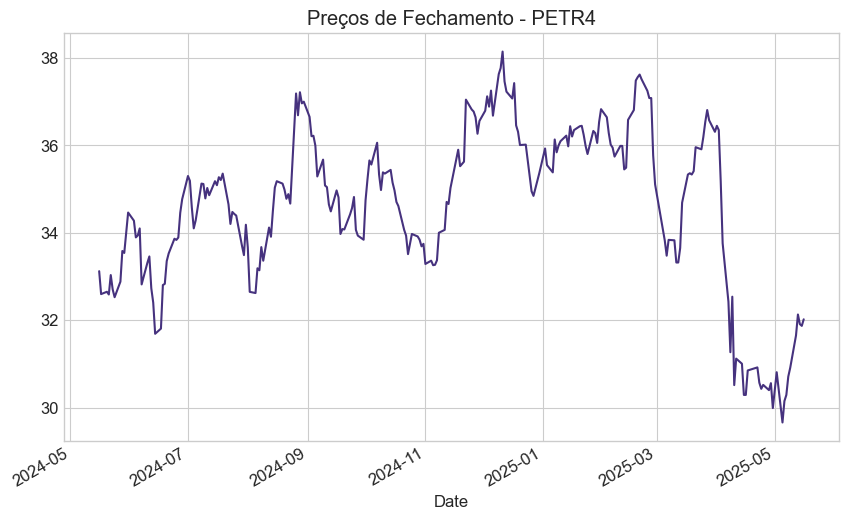

In [13]:
def get_stock_data(ticker_list, period='1y'):
    """
    Obtém dados históricos para uma lista de tickers usando yfinance.
    
    Args:
        ticker_list: Lista de tickers
        period: Período para obter dados (ex: '1y', '2y', '5y')
        
    Returns:
        Dicionário com dados históricos para cada ticker
    """
    print("=" * 50)
    print(f">>> INICIANDO: Obtendo dados históricos para {len(ticker_list)} ações")
    print("=" * 50)
    
    # Inicializar contadores e resultados
    data = {}
    successful = 0
    failed = 0
    start_time = datetime.now()
    
    # Registrar data de início para exportação
    with open(os.path.join(data_dir, "data_extraction_log.txt"), "w") as log_file:
        log_file.write(f"Extracao iniciada em: {start_time}\n")
        log_file.write(f"Periodo solicitado: {period}\n")
        log_file.write(f"Numero de tickers: {len(ticker_list)}\n\n")
        log_file.write("REGISTRO DE EXTRACAO:\n")
    
    # Obter dados para cada ticker (limitado a 5 para demonstração)
    for i, ticker in enumerate(ticker_list[:5]):
        try:
            print(f"[{i+1}/{len(ticker_list[:5])}] Obtendo dados para {ticker}...", end="")
            
            # Adicionar .SA para ações brasileiras
            ticker_yf = f"{ticker}.SA"
            
            # Obter dados históricos
            stock = yf.Ticker(ticker_yf)
            hist = stock.history(period=period)
            
            # Verificar se há dados suficientes
            if len(hist) > 30:
                data[ticker] = hist
                successful += 1
                status = f"OK ({len(hist)} dias)"
            else:
                failed += 1
                status = f"ERRO: Dados insuficientes ({len(hist)} dias)"
                
            print(f" {status}")
            
            # Registrar no log
            with open(os.path.join(data_dir, "data_extraction_log.txt"), "a", encoding='ascii', errors='replace') as log_file:
                log_file.write(f"{ticker}: {status}\n")
                
        except Exception as e:
            failed += 1
            print(f" ERRO: {str(e)}")
            
            # Registrar erro no log
            with open(os.path.join(data_dir, "data_extraction_log.txt"), "a", encoding='ascii', errors='replace') as log_file:
                log_file.write(f"{ticker}: ERRO - {str(e)}\n")
    
    # Calcular taxa de sucesso e tempo decorrido
    end_time = datetime.now()
    elapsed_time = (end_time - start_time).total_seconds()
    success_rate = (successful / len(ticker_list[:5])) * 100
    
    # Estatísticas finais
    print("\n=== Estatisticas de Extracao ===")
    print(f"Acoes com dados validos: {successful}/{len(ticker_list[:5])} ({success_rate:.1f}%)")
    print(f"Acoes com falha: {failed}/{len(ticker_list[:5])} ({100-success_rate:.1f}%)")
    print(f"Tempo total: {elapsed_time:.1f} segundos")
    
    # Mostrar exemplo dos dados obtidos para o primeiro ticker bem-sucedido
    if data:
        first_ticker = list(data.keys())[0]
        print(f"\nExemplo de dados para {first_ticker}:")
        print(data[first_ticker].head())
        
        # Gráfico de exemplo para o primeiro ticker
        plt.figure(figsize=(10, 6))
        data[first_ticker]['Close'].plot(title=f'Preços de Fechamento - {first_ticker}')
        plt.grid(True)
        plt.show()
    
    print("=" * 50)
    return data

# Obtendo dados para demonstração (limitado a 5 tickers)
stock_data = get_stock_data(tickers, period='1y')


## Obtenção de Metadados das Ações  

A função abaixo obtém metadados das ações como nome da empresa, setor, indústria, etc.

In [14]:
def get_stock_metadata(ticker_list):
    """
    Obtém metadados (nome, setor, etc.) para integração com o backend.
    
    Args:
        ticker_list: Lista de tickers
        
    Returns:
        DataFrame com metadados das ações
    """
    print("=" * 50)
    print(f">>> INICIANDO: Obtendo metadados para {len(ticker_list)} ações")
    print("=" * 50)
    
    # Definir colunas para o DataFrame de metadados
    metadata_columns = [
        'symbol', 'name', 'sector', 'industry', 'website',
        'description', 'market_cap', 'pe_ratio', 'dividend_yield'
    ]
    
    # Inicializar DataFrame vazio
    metadata_df = pd.DataFrame(columns=metadata_columns)
    
    # Contadores para estatísticas
    successful = 0
    failed = 0
    
    # Obter dados para cada ticker (limitado a 3 para demonstração)
    for i, ticker in enumerate(ticker_list[:3]):
        try:
            print(f"[{i+1}/{len(ticker_list[:3])}] Obtendo metadados para {ticker}...", end="")
            
            # Remover sufixo .SA se houver
            clean_ticker = ticker.replace('.SA', '')
            
            # Buscar dados completos via yfinance
            stock = yf.Ticker(f"{clean_ticker}.SA")
            info = stock.info
            
            # Criar novo registro para o DataFrame
            new_row = pd.DataFrame([{
                'symbol': clean_ticker,
                'name': info.get('longName', f'Empresa {clean_ticker}'),
                'sector': info.get('sector', 'Setor não classificado'),
                'industry': info.get('industry', ''),
                'website': info.get('website', ''),
                'description': info.get('longBusinessSummary', '')[:500],  # Limitar tamanho
                'market_cap': info.get('marketCap', 0),
                'pe_ratio': info.get('trailingPE', None),
                'dividend_yield': info.get('dividendYield', None)
            }])
            
            # Adicionar ao DataFrame de metadados
            metadata_df = pd.concat([metadata_df, new_row], ignore_index=True)
            
            successful += 1
            print(f" OK")
            
        except Exception as e:
            failed += 1
            print(f" ERRO: {str(e)}")
            
            # Adicionar entrada com dados básicos em caso de erro
            new_row = pd.DataFrame([{
                'symbol': ticker.replace('.SA', ''),
                'name': f'Empresa {ticker}',
                'sector': 'Setor não classificado',
                'industry': '',
                'website': '',
                'description': '',
                'market_cap': 0,
                'pe_ratio': None,
                'dividend_yield': None
            }])
            metadata_df = pd.concat([metadata_df, new_row], ignore_index=True)
    
    # Exibir resultado
    print("\n=== Metadados obtidos ===")
    display(metadata_df)
    
    # Salvar metadados em CSV
    metadata_path = os.path.join(data_dir, "stocks_metadata.csv")
    metadata_df.to_csv(metadata_path, index=False)
    print(f"Metadados salvos em: {metadata_path}")
    
    return metadata_df

# Obtendo metadados para demonstração (limitado a 3 tickers)
metadata_df = get_stock_metadata(tickers)


>>> INICIANDO: Obtendo metadados para 50 ações
[1/3] Obtendo metadados para PETR4... OK
[2/3] Obtendo metadados para VALE3... OK
[3/3] Obtendo metadados para ITUB4... OK

=== Metadados obtidos ===


,symbol,name,sector,industry,website,description,market_cap,pe_ratio,dividend_yield
0,PETR4,Petróleo Brasileiro S.A. - Petrobras,Energy,Oil & Gas Integrated,https://petrobras.com.br,"Petróleo Brasileiro S.A. - Petrobras explores,...",428549275648,8.404200,15.93
1,VALE3,Vale S.A.,Basic Materials,Other Industrial Metals & Mining,https://www.vale.com,"Vale S.A., together with its subsidiaries, pro...",236874612736,7.068790,13.51
2,ITUB4,Itaú Unibanco Holding S.A.,Financial Services,Banks - Regional,https://www.itau.com.br,Itaú Unibanco Holding S.A. provides various fi...,385367244800,10.000001,0.56


Metadados salvos em: C:\stock-advisor-backend\data\stocks_metadata.csv


## Cálculo de Métricas de Risco

As funções abaixo calculam as principais métricas de risco para cada ação:
- Volatilidade (desvio padrão dos retornos anualizados)
- Drawdown máximo (maior queda percentual do valor no período)
- Beta (sensibilidade em relação ao IBOVESPA)
- Liquidez (volume médio de negociação)

>>> INICIANDO: Calculando métricas de risco
Dados do IBOVESPA obtidos com sucesso

Primeiros dados do IBOVESPA:


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns
Date,,,,,,,,
2024-05-16 00:00:00-03:00,128029.0,128965.0,127922.0,128284.0,9852200,0.0,0.0,NaN
2024-05-17 00:00:00-03:00,128280.0,128464.0,127696.0,128151.0,10262600,0.0,0.0,-0.001037
2024-05-20 00:00:00-03:00,128151.0,128730.0,127488.0,127751.0,9340300,0.0,0.0,-0.003121


Calculando métricas para PETR4... OK
Calculando métricas para VALE3... OK
Calculando métricas para ITUB4... OK
Calculando métricas para BBDC4... OK
Calculando métricas para ABEV3... OK

=== Métricas de Risco Calculadas ===


,Ticker,Volatility,Max_Drawdown,Beta,Liquidity
0,PETR4,0.239204,0.222435,0.782901,35.263010
1,VALE3,0.249099,0.197253,0.898789,23.864578
2,ITUB4,0.207635,0.203098,0.957975,25.902647
3,BBDC4,0.292847,0.269505,1.271570,38.901000
4,ABEV3,0.225410,0.208296,0.704441,32.714030


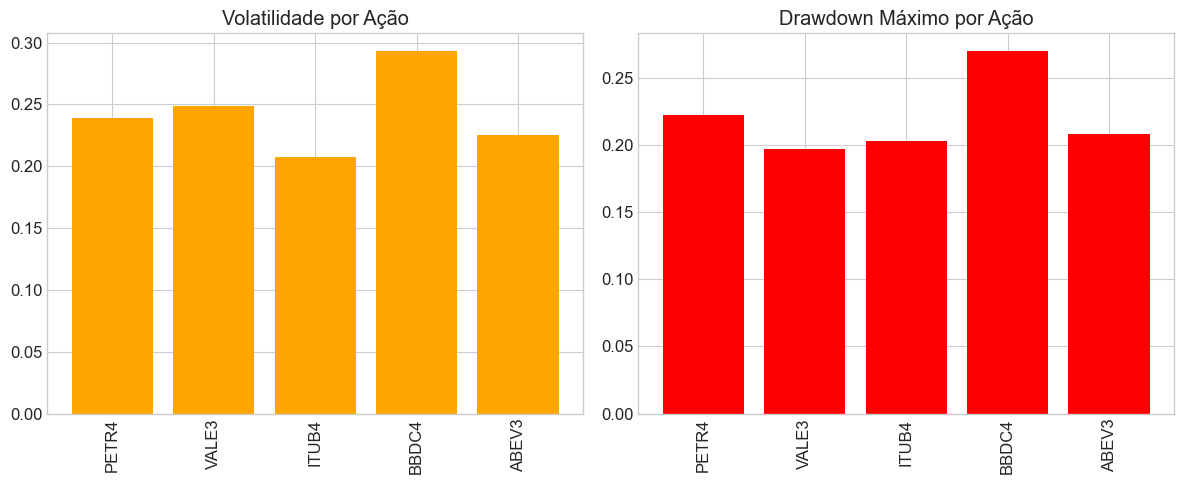

Métricas de risco salvas em: C:\stock-advisor-backend\data\risk_metrics_raw.csv


In [15]:
def calculate_returns(data):
    """
    Calcula retornos diários.
    
    Args:
        data: DataFrame com preços históricos
        
    Returns:
        DataFrame com retornos adicionados
    """
    data_copy = data.copy()
    data_copy['Returns'] = data_copy['Close'].pct_change()
    return data_copy

def calculate_risk_metrics(stock_data):
    """
    Calcula métricas de risco para cada ação.
    
    Args:
        stock_data: Dicionário com dados históricos das ações
        
    Returns:
        DataFrame com métricas de risco
    """
    print("=" * 50)
    print(">>> INICIANDO: Calculando métricas de risco")
    print("=" * 50)
    
    # Obter dados do IBOVESPA para cálculo do Beta
    try:
        ibov = yf.Ticker('^BVSP').history(period='1y')
        ibov['Returns'] = ibov['Close'].pct_change()
        print("Dados do IBOVESPA obtidos com sucesso")
        
        # Mostrar os primeiros dados do IBOVESPA
        print("\nPrimeiros dados do IBOVESPA:")
        display(ibov.head(3))
    except Exception as e:
        print(f"ERRO ao obter dados do IBOVESPA: {e}")
        ibov = None
    
    # Lista para armazenar resultados
    results = []
    
    # Processar cada ação
    for ticker, data in stock_data.items():
        try:
            print(f"Calculando métricas para {ticker}...", end="")
            
            # Calcular retornos diários
            data = calculate_returns(data)
            
            # 1. Volatilidade (anualizada)
            volatility = data['Returns'].std() * (252 ** 0.5)
            
            # 2. Drawdown máximo
            cumulative_returns = (1 + data['Returns'].fillna(0)).cumprod()
            running_max = cumulative_returns.cummax()
            drawdown = (cumulative_returns / running_max) - 1
            max_drawdown = abs(drawdown.min())
            
            # 3. Beta (em relação ao IBOVESPA)
            beta = np.nan
            if ibov is not None:
                # Converter o conjunto para lista antes de usar como índice
                common_dates = list(set(data.index) & set(ibov.index))
                if len(common_dates) > 30:
                    # Ordenar as datas para garantir alinhamento correto
                    common_dates.sort()
                    df_merged = pd.DataFrame({
                        'stock': data.loc[common_dates, 'Returns'],
                        'market': ibov.loc[common_dates, 'Returns']
                    }).dropna()
                    
                    covariance = df_merged['stock'].cov(df_merged['market'])
                    market_variance = df_merged['market'].var()
                    beta = covariance / market_variance if market_variance > 0 else np.nan
            
            # 4. Liquidez (volume médio normalizado em milhões)
            liquidity = data['Volume'].mean() / 1_000_000
            
            # Adicionar aos resultados
            results.append({
                'Ticker': ticker,
                'Volatility': volatility,
                'Max_Drawdown': max_drawdown,
                'Beta': beta,
                'Liquidity': liquidity
            })
            
            print(f" OK")
            
        except Exception as e:
            print(f" ERRO: {str(e)}")
    
    # Criar DataFrame com os resultados
    metrics_df = pd.DataFrame(results)
    
    # Exibir resultados
    print("\n=== Métricas de Risco Calculadas ===")
    display(metrics_df)
    
    # Visualização das métricas de risco
    if len(metrics_df) > 0:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.bar(metrics_df['Ticker'], metrics_df['Volatility'], color='orange')
        plt.title('Volatilidade por Ação')
        plt.xticks(rotation=90)
        
        plt.subplot(1, 2, 2)
        plt.bar(metrics_df['Ticker'], metrics_df['Max_Drawdown'], color='red')
        plt.title('Drawdown Máximo por Ação')
        plt.xticks(rotation=90)
        
        plt.tight_layout()
        plt.show()
    
    # Salvar métricas em CSV
    if len(metrics_df) > 0:
        metrics_path = os.path.join(data_dir, "risk_metrics_raw.csv") 
        metrics_df.to_csv(metrics_path, index=False)
        print(f"Métricas de risco salvas em: {metrics_path}")
    
    return metrics_df

# Calcular métricas de risco
risk_metrics = calculate_risk_metrics(stock_data)


## Classificação de Risco das Ações

Esta função classifica as ações em 5 níveis de risco:
1. Muito Baixo
2. Baixo
3. Médio
4. Alto
5. Muito Alto

A classificação utiliza o algoritmo K-Means para agrupar as ações com base em suas métricas de risco.

In [17]:
def classify_risk(metrics_df):
    """
    Classifica o risco das ações em 5 níveis.
    
    Args:
        metrics_df: DataFrame com métricas de risco
        
    Returns:
        DataFrame com classificação de risco
    """
    print("=" * 50)
    print(">>> INICIANDO: Classificando ações por nível de risco")
    print("=" * 50)
    
    # Verificar se temos dados para classificar
    if len(metrics_df) == 0 or 'Volatility' not in metrics_df.columns:
        print("AVISO: Não há dados suficientes para classificação de risco.")
        return pd.DataFrame(columns=[
            'Ticker', 'Volatility', 'Max_Drawdown', 'Beta', 'Liquidity',
            'Risk_Level', 'Risk_Description'
        ])
    
    # Copiar DataFrame para não modificar o original
    df = metrics_df.copy()
    
    # Remover linhas com valores NaN (necessário para K-means)
    df_clean = df.dropna()
    print(f"Ações válidas para classificação: {len(df_clean)}/{len(df)}")
    
    # Verificar se há dados suficientes
    if len(df_clean) < 5:
        print("AVISO: Número insuficiente de ações para classificação com K-means!")
        # Classificação manual como fallback
        df['Risk_Level'] = df['Volatility'].apply(
            lambda x: 1 if x < 0.15 else 
                     (2 if x < 0.25 else 
                     (3 if x < 0.35 else 
                     (4 if x < 0.45 else 5)))
        )
        print("Usando classificação baseada apenas em volatilidade como fallback")
    else:
        # Normalizar os dados para o K-means
        scaler = StandardScaler()
        features = ['Volatility', 'Max_Drawdown', 'Beta', 'Liquidity']
        # Filtrar somente as colunas disponíveis
        available_features = [f for f in features if f in df_clean.columns]
        
        print(f"\nCaracterísticas utilizadas para classificação: {available_features}")
        
        X = scaler.fit_transform(df_clean[available_features])
        
        # Classificação com K-means (5 clusters = 5 níveis de risco)
        kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
        df_clean['Risk_Level'] = kmeans.fit_predict(X) + 1  # +1 para começar em 1 em vez de 0
        
        # Ordenar os níveis de risco pela volatilidade média
        risk_metrics = df_clean.groupby('Risk_Level')[['Volatility', 'Max_Drawdown']].mean()
        combined_risk = risk_metrics['Volatility'] + risk_metrics['Max_Drawdown']
        risk_order = combined_risk.sort_values().index
        
        print("\nNíveis de risco antes do reordenamento:")
        print(risk_metrics)
        
        # Reordenar níveis para garantir que 1=menor risco, 5=maior risco
        risk_map = {old_level: new_level for new_level, old_level in enumerate(risk_order, 1)}
        df_clean['Risk_Level'] = df_clean['Risk_Level'].map(risk_map)
        
        # Mesclar resultados com o DataFrame original
        df = df.merge(df_clean[['Ticker', 'Risk_Level']], on='Ticker', how='left')
        
        print("\nNíveis de risco após reordenamento:")
        display(df.groupby('Risk_Level')[['Volatility', 'Max_Drawdown']].mean())
    
    # Verificar se há valores nulos na classificação
    null_mask = df['Risk_Level'].isnull()
    if null_mask.any():
        print(f"AVISO: {null_mask.sum()} ações não puderam ser classificadas pelo modelo")
        print("Aplicando classificação baseada em volatilidade para ações não classificadas")
        
        # Classificação manual para valores nulos
        df.loc[null_mask, 'Risk_Level'] = df.loc[null_mask, 'Volatility'].apply(
            lambda x: 1 if x < 0.15 else 
                     (2 if x < 0.25 else 
                     (3 if x < 0.35 else 
                     (4 if x < 0.45 else 5)))
        )
    
    # Garantir que Risk_Level seja inteiro
    df['Risk_Level'] = df['Risk_Level'].astype(int)
    
    # Adicionar descrição textual
    risk_labels = {
        1: 'Muito Baixo',
        2: 'Baixo',
        3: 'Médio',
        4: 'Alto',
        5: 'Muito Alto'
    }
    df['Risk_Description'] = df['Risk_Level'].map(risk_labels)
    
    # Mostrar estatísticas da classificação
    level_counts = df['Risk_Level'].value_counts().sort_index()
    print("\n=== Distribuição dos Níveis de Risco ===")
    for level, count in level_counts.items():
        print(f"Nível {level} ({risk_labels[level]}): {count} ações")
    
    # Exibir DataFrame final
    print("\n=== Classificação Final ===")
    display(df)
    
    # Salvar classificação em CSV para o backend
    classification_path = os.path.join(data_dir, "classified_stocks_b3.csv")
    df.to_csv(classification_path, index=False)
    print(f"Classificação de risco salva em: {classification_path}")
    
    return df

# Classificar as ações por nível de risco
classified_stocks = classify_risk(risk_metrics)


>>> INICIANDO: Classificando ações por nível de risco
Ações válidas para classificação: 5/5

Características utilizadas para classificação: ['Volatility', 'Max_Drawdown', 'Beta', 'Liquidity']

Níveis de risco antes do reordenamento:
            Volatility  Max_Drawdown
Risk_Level                          
1             0.249099      0.197253
2             0.292847      0.269505
3             0.239204      0.222435
4             0.207635      0.203098
5             0.225410      0.208296

Níveis de risco após reordenamento:


,Volatility,Max_Drawdown
Risk_Level,,
1,0.207635,0.203098
2,0.225410,0.208296
3,0.249099,0.197253
4,0.239204,0.222435
5,0.292847,0.269505



=== Distribuição dos Níveis de Risco ===
Nível 1 (Muito Baixo): 1 ações
Nível 2 (Baixo): 1 ações
Nível 3 (Médio): 1 ações
Nível 4 (Alto): 1 ações
Nível 5 (Muito Alto): 1 ações

=== Classificação Final ===


,Ticker,Volatility,Max_Drawdown,Beta,Liquidity,Risk_Level,Risk_Description
0,PETR4,0.239204,0.222435,0.782901,35.263010,4,Alto
1,VALE3,0.249099,0.197253,0.898789,23.864578,3,Médio
2,ITUB4,0.207635,0.203098,0.957975,25.902647,1,Muito Baixo
3,BBDC4,0.292847,0.269505,1.271570,38.901000,5,Muito Alto
4,ABEV3,0.225410,0.208296,0.704441,32.714030,2,Baixo


Classificação de risco salva em: C:\stock-advisor-backend\data\classified_stocks_b3.csv


## Visualização da Distribuição de Risco

Esta função cria visualizações para analisar a distribuição dos níveis de risco e como as diferentes métricas se relacionam com cada nível.

>>> INICIANDO: Gerando visualizações da classificação de risco


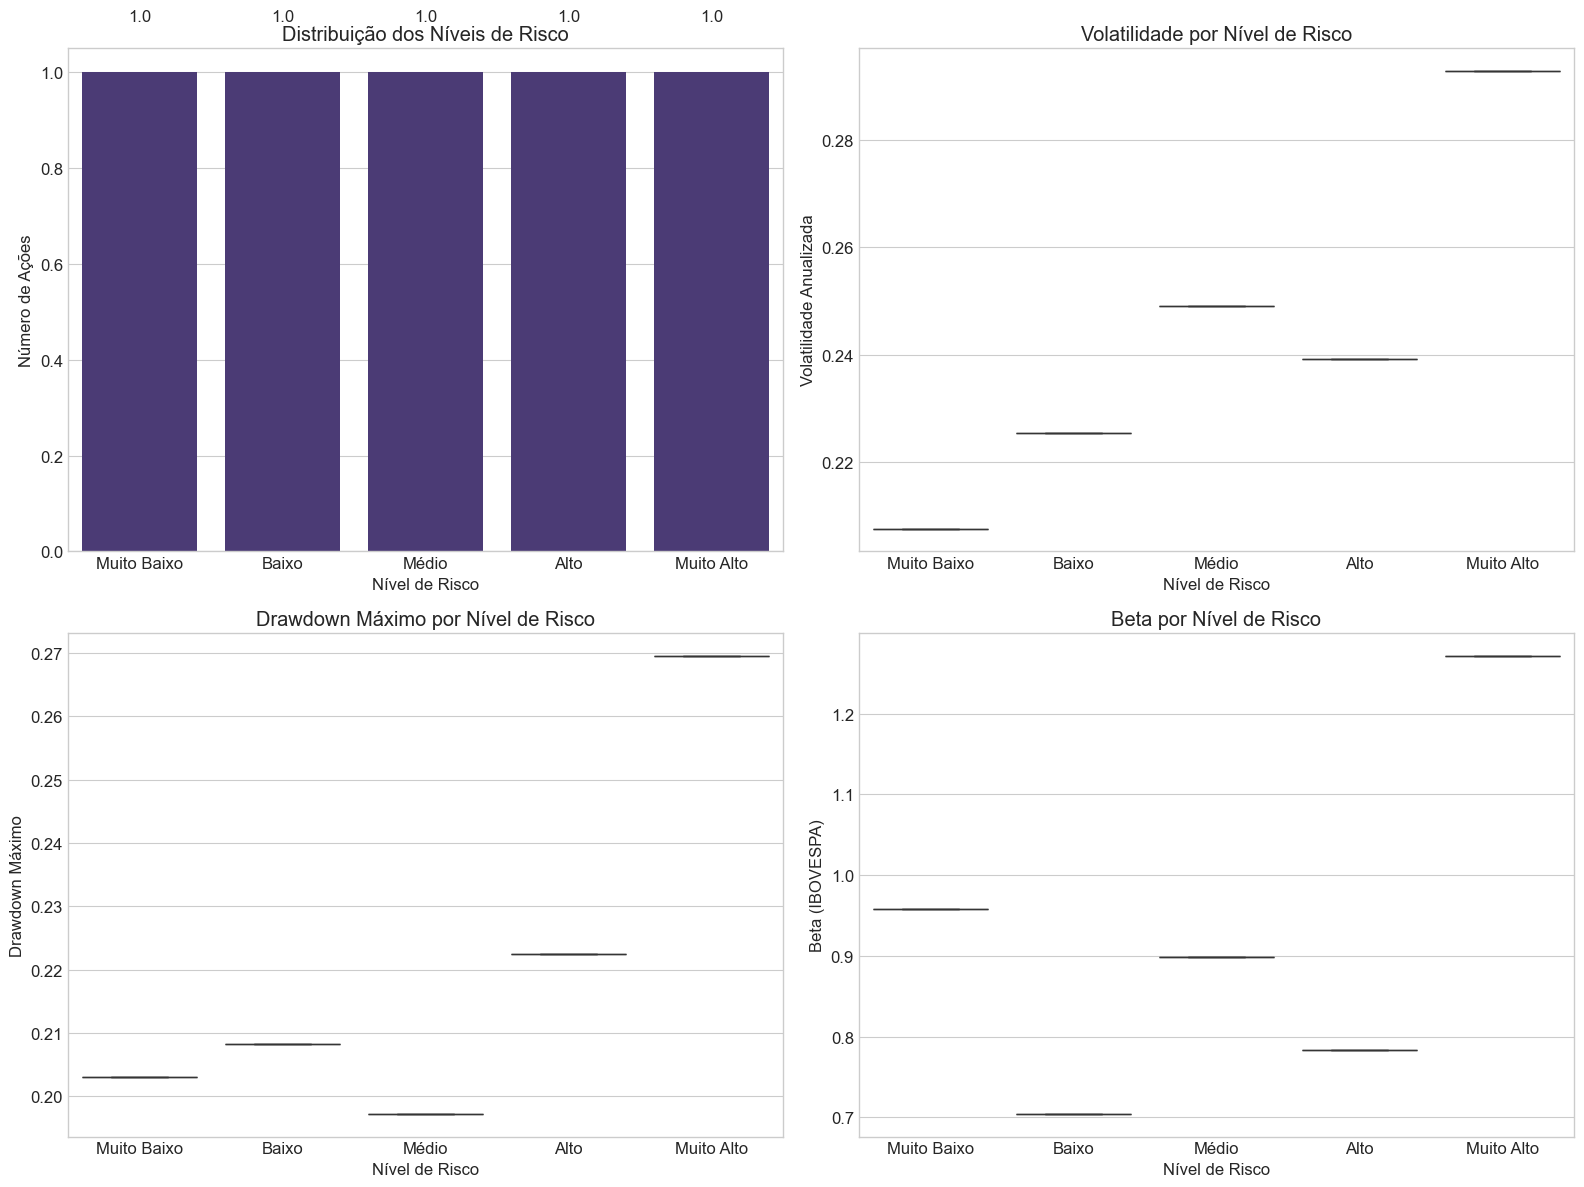


=== Estatísticas por Nível de Risco ===


,Volatility,Max_Drawdown,Beta,Liquidity
Risk_Description,,,,
Alto,0.2392,0.2224,0.7829,35.2630
Baixo,0.2254,0.2083,0.7044,32.7140
Muito Alto,0.2928,0.2695,1.2716,38.9010
Muito Baixo,0.2076,0.2031,0.9580,25.9026
Médio,0.2491,0.1973,0.8988,23.8646


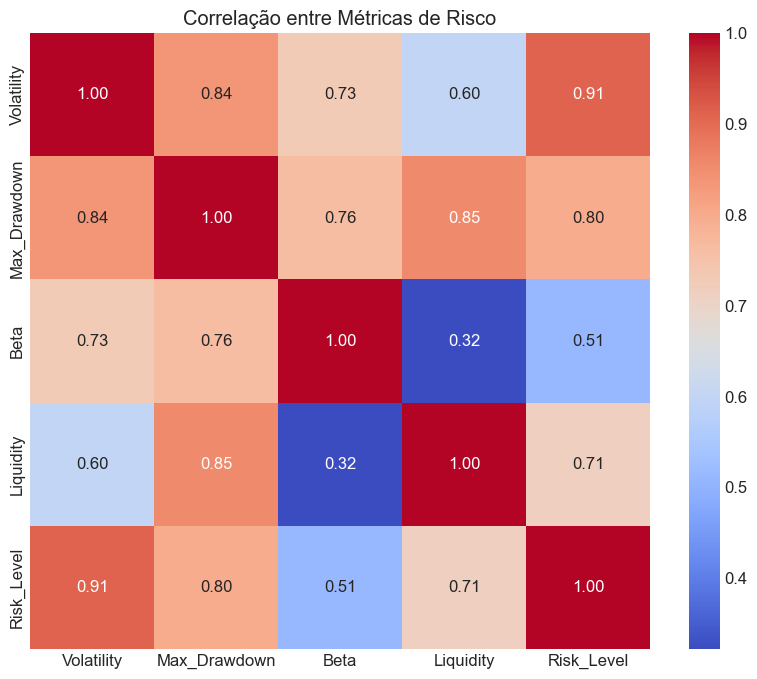

Visualizações salvas em: C:\stock-advisor-backend\data\risk_classification_viz.png


In [18]:
def plot_risk_distribution(classified_stocks):
    """
    Visualiza a distribuição dos níveis de risco.
    
    Args:
        classified_stocks: DataFrame com as ações classificadas
    """
    # Verificar se há dados para visualização
    if len(classified_stocks) == 0 or 'Risk_Level' not in classified_stocks.columns:
        print("AVISO: Não há dados suficientes para gerar visualizações")
        return
    
    print("=" * 50)
    print(">>> INICIANDO: Gerando visualizações da classificação de risco")
    print("=" * 50)
    
    try:
        # Configurar figura
        plt.figure(figsize=(16, 12))
        
        # 1. Distribuição de níveis de risco
        plt.subplot(2, 2, 1)
        ax = sns.countplot(x='Risk_Description', data=classified_stocks, 
                      order=['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto'])
        plt.title('Distribuição dos Níveis de Risco')
        plt.xlabel('Nível de Risco')
        plt.ylabel('Número de Ações')
        
        # Adicionar rótulos de contagem nas barras
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width()/2., height + 0.1, height, 
                   ha="center", va="bottom")
        
        # 2. Volatilidade por nível de risco
        plt.subplot(2, 2, 2)
        sns.boxplot(x='Risk_Description', y='Volatility', data=classified_stocks,
                   order=['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto'])
        plt.title('Volatilidade por Nível de Risco')
        plt.xlabel('Nível de Risco')
        plt.ylabel('Volatilidade Anualizada')
        
        # 3. Drawdown por nível de risco
        plt.subplot(2, 2, 3)
        sns.boxplot(x='Risk_Description', y='Max_Drawdown', data=classified_stocks,
                   order=['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto'])
        plt.title('Drawdown Máximo por Nível de Risco')
        plt.xlabel('Nível de Risco')
        plt.ylabel('Drawdown Máximo')
        
        # 4. Beta por nível de risco
        plt.subplot(2, 2, 4)
        sns.boxplot(x='Risk_Description', y='Beta', data=classified_stocks,
                   order=['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto'])
        plt.title('Beta por Nível de Risco')
        plt.xlabel('Nível de Risco')
        plt.ylabel('Beta (IBOVESPA)')
        
        plt.tight_layout()
        plt.show()
        
        # Exibir estatísticas descritivas por nível de risco
        print("\n=== Estatísticas por Nível de Risco ===")
        stats = classified_stocks.groupby('Risk_Description')[['Volatility', 'Max_Drawdown', 'Beta', 'Liquidity']].mean().round(4)
        display(stats)
        
        # Correlação entre métricas
        plt.figure(figsize=(10, 8))
        correlation = classified_stocks[['Volatility', 'Max_Drawdown', 'Beta', 'Liquidity', 'Risk_Level']].corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Correlação entre Métricas de Risco')
        plt.show()
        
        # Salvar visualização
        viz_path = os.path.join(data_dir, "risk_classification_viz.png")
        plt.figure(figsize=(16, 12))
        
        # Distribuição de níveis de risco (para salvar)
        plt.subplot(2, 2, 1)
        sns.countplot(x='Risk_Description', data=classified_stocks,
                     order=['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto'])
        plt.title('Distribuição dos Níveis de Risco')
        plt.xlabel('Nível de Risco')
        plt.ylabel('Número de Ações')
        
        # Volatilidade por nível de risco (para salvar)
        plt.subplot(2, 2, 2)
        sns.boxplot(x='Risk_Description', y='Volatility', data=classified_stocks,
                   order=['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto'])
        plt.title('Volatilidade por Nível de Risco')
        plt.xlabel('Nível de Risco')
        plt.ylabel('Volatilidade Anualizada')
        
        plt.tight_layout()
        plt.savefig(viz_path, dpi=150)
        plt.close()
        
        print(f"Visualizações salvas em: {viz_path}")
        
    except Exception as e:
        print(f"ERRO ao gerar visualizações: {str(e)}")
        
    print("=" * 50)
    return

# Gerar visualizações
plot_risk_distribution(classified_stocks)


## Função Principal e Execução

A função abaixo integra todas as etapas anteriores e executa o fluxo completo de classificação de risco.

===== CLASSIFICAÇÃO DE RISCO DE AÇÕES DA B3 =====
Configurações da execução:
  - execution_time: 2025-05-18 19:55:35
  - num_stocks: 10
  - data_directory: C:\stock-advisor-backend\data

1. Obtendo lista de tickers...

>>> INICIANDO: Obtendo lista de tickers da B3
Selecionados 10 tickers
Primeiros 5: ['PETR4', 'VALE3', 'ITUB4', 'BBDC4', 'ABEV3']
Últimos 5: ['B3SA3', 'WEGE3', 'RENT3', 'BBAS3', 'PETR3']
Lista de tickers salva em: C:\stock-advisor-backend\data\b3_tickers.csv

2. Obtendo metadados...

>>> INICIANDO: Obtendo metadados para 10 ações
[1/10] Obtendo metadados para PETR4... OK
[2/10] Obtendo metadados para VALE3... OK
[3/10] Obtendo metadados para ITUB4... OK
[4/10] Obtendo metadados para BBDC4... OK
[5/10] Obtendo metadados para ABEV3... OK
[6/10] Obtendo metadados para B3SA3... OK
[7/10] Obtendo metadados para WEGE3... OK
[8/10] Obtendo metadados para RENT3... OK
[9/10] Obtendo metadados para BBAS3... OK
[10/10] Obtendo metadados para PETR3... OK

=== Estatisticas de Metadado

,Volatility,Max_Drawdown
Risk_Level,,
1,0.226079,0.187319
2,0.232307,0.215366
3,0.291292,0.257491
4,0.316618,0.278716
5,0.449615,0.426407



=== Distribuição dos Níveis de Risco ===
Nível 1 (Muito Baixo): 3 ações
Nível 2 (Baixo): 2 ações
Nível 3 (Médio): 2 ações
Nível 4 (Alto): 2 ações
Nível 5 (Muito Alto): 1 ações

=== Classificação Final ===


,Ticker,Volatility,Max_Drawdown,Beta,Liquidity,Risk_Level,Risk_Description
0,PETR4,0.239204,0.222435,0.782902,35.263010,2,Baixo
1,VALE3,0.249099,0.197253,0.898789,23.864578,1,Muito Baixo
2,ITUB4,0.207635,0.203098,0.957975,25.902647,1,Muito Baixo
3,BBDC4,0.292847,0.269505,1.271570,38.901000,4,Alto
4,ABEV3,0.225410,0.208296,0.704441,32.714030,2,Baixo
5,B3SA3,0.340390,0.287927,1.634607,46.730349,4,Alto
6,WEGE3,0.312352,0.279513,0.683059,7.139160,3,Médio
7,RENT3,0.449615,0.426407,1.635945,10.308828,5,Muito Alto
8,BBAS3,0.221504,0.161605,0.735756,18.702230,1,Muito Baixo
9,PETR3,0.270232,0.235469,0.860694,10.066511,3,Médio


Classificação de risco salva em: C:\stock-advisor-backend\data\classified_stocks_b3.csv

6. Gerando visualizações...
>>> INICIANDO: Gerando visualizações da classificação de risco


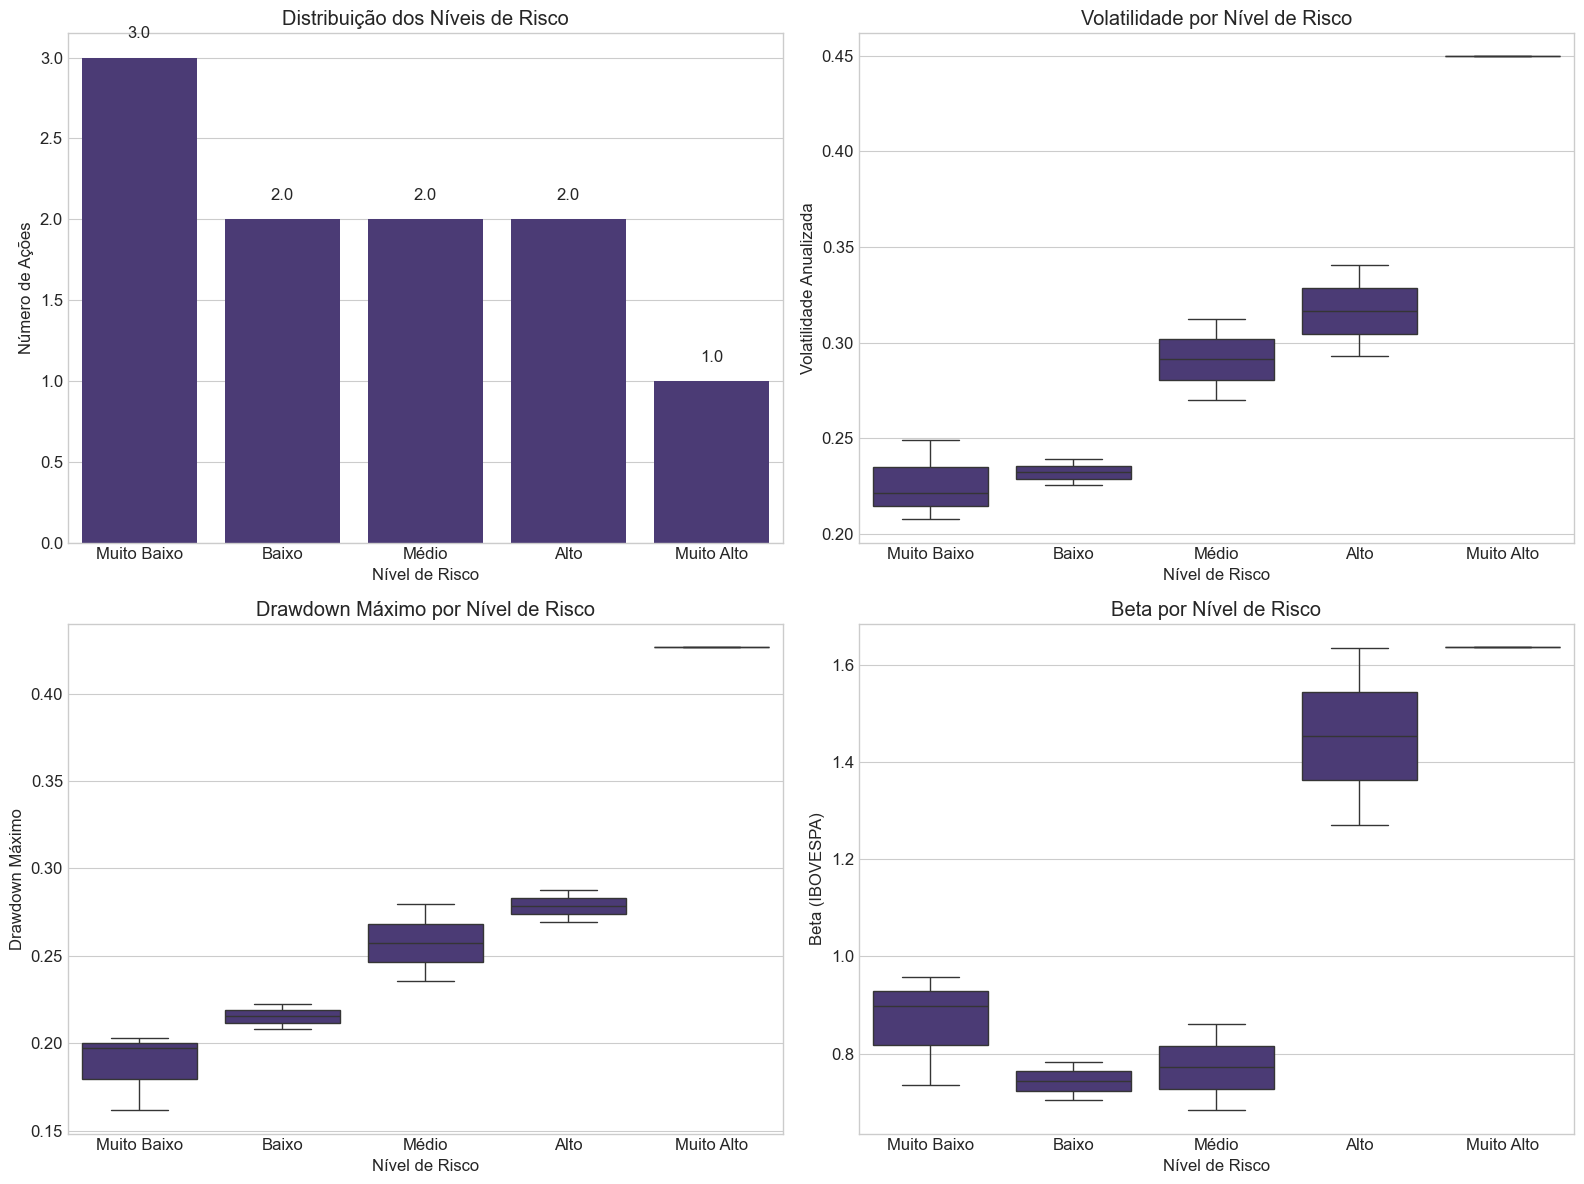


=== Estatísticas por Nível de Risco ===


,Volatility,Max_Drawdown,Beta,Liquidity
Risk_Description,,,,
Alto,0.3166,0.2787,1.4531,42.8157
Baixo,0.2323,0.2154,0.7437,33.9885
Muito Alto,0.4496,0.4264,1.6359,10.3088
Muito Baixo,0.2261,0.1873,0.8642,22.8232
Médio,0.2913,0.2575,0.7719,8.6028


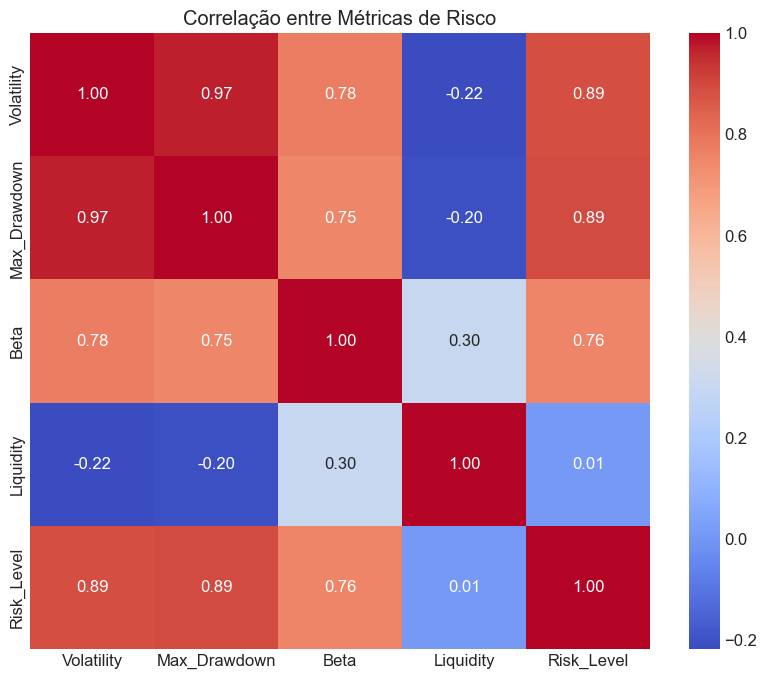

Visualizações salvas em: C:\stock-advisor-backend\data\risk_classification_viz.png

RESUMO DOS DADOS GERADOS:
Tickers B3: 10 ações [b3_tickers.csv]
Metadados: 10 registros [stocks_metadata.csv]
Dados históricos: 10 ações processadas
Métricas de risco: 10 ações analisadas [risk_metrics_raw.csv]
Classificação final: 10 ações classificadas [classified_stocks_b3.csv]

Arquivos gerados no diretório: C:\stock-advisor-backend\data

Processo finalizado com sucesso!


In [19]:
def main(num_stocks=50, plot_charts=True):
    """
    Executa o fluxo completo de classificação de risco.
    
    Args:
        num_stocks: Número de ações a processar
        plot_charts: Se True, gera visualizações
        
    Returns:
        DataFrame com as ações classificadas
    """
    print("=" * 70)
    print("===== CLASSIFICAÇÃO DE RISCO DE AÇÕES DA B3 =====")
    print("=" * 70)
    
    # Registrar configurações
    config = {
        'execution_time': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'num_stocks': num_stocks,
        'data_directory': os.path.abspath(data_dir)
    }
    
    print("Configurações da execução:")
    for key, value in config.items():
        print(f"  - {key}: {value}")
    
    with open(os.path.join(data_dir, "execution_config.txt"), "w", encoding='ascii', errors='replace') as f:
        for key, value in config.items():
            f.write(f"{key}: {value}\n")
    
    try:
        # 1. Obter lista de tickers
        print("\n1. Obtendo lista de tickers...")
        tickers = get_b3_tickers(num_stocks)
        
        # 2. Obter metadados para integração com o backend
        print("\n2. Obtendo metadados...")
        metadata_df = get_stock_metadata(tickers)
        
        # 3. Obter dados históricos
        print("\n3. Obtendo dados históricos...")
        stock_data = get_stock_data(tickers, period='1y')
        
        # 4. Calcular métricas de risco
        print("\n4. Calculando métricas de risco...")
        risk_metrics = calculate_risk_metrics(stock_data)
        
        # 5. Classificar risco
        print("\n5. Classificando ações por nível de risco...")
        classified_stocks = classify_risk(risk_metrics)
        
        # 6. Gerar visualizações (opcional)
        if plot_charts:
            print("\n6. Gerando visualizações...")
            plot_risk_distribution(classified_stocks)
        
        # 7. Resumo dos dados gerados
        print("\n" + "=" * 50)
        print("RESUMO DOS DADOS GERADOS:")
        print("=" * 50)
        print(f"Tickers B3: {len(tickers)} ações [b3_tickers.csv]")
        print(f"Metadados: {len(metadata_df)} registros [stocks_metadata.csv]")
        print(f"Dados históricos: {len(stock_data)} ações processadas")
        print(f"Métricas de risco: {len(risk_metrics)} ações analisadas [risk_metrics_raw.csv]")
        print(f"Classificação final: {len(classified_stocks)} ações classificadas [classified_stocks_b3.csv]")
        print("\nArquivos gerados no diretório: " + os.path.abspath(data_dir))
        print("=" * 50)
        
        return classified_stocks
    
    except Exception as e:
        print(f"\nERRO CRÍTICO: {str(e)}")
        print("O processo foi interrompido devido a um erro.")
        print("Verifique as mensagens acima para mais detalhes.")
        return pd.DataFrame()

# Executar o programa principal (versão demonstração com menos ações)
classified_stocks = main(num_stocks=10, plot_charts=True)
print("\nProcesso finalizado com sucesso!")


## Análise Final dos Resultados

Abaixo analisamos os resultados finais da classificação de risco das ações.

AÇÕES AGRUPADAS POR NÍVEL DE RISCO

Nível 1 - Muito Baixo (3 ações):
  1. VALE3 - Vol: 0.249, DD: 0.197, Beta: 0.90
  2. ITUB4 - Vol: 0.208, DD: 0.203, Beta: 0.96
  3. BBAS3 - Vol: 0.222, DD: 0.162, Beta: 0.74

Nível 2 - Baixo (2 ações):
  1. PETR4 - Vol: 0.239, DD: 0.222, Beta: 0.78
  2. ABEV3 - Vol: 0.225, DD: 0.208, Beta: 0.70

Nível 3 - Médio (2 ações):
  1. WEGE3 - Vol: 0.312, DD: 0.280, Beta: 0.68
  2. PETR3 - Vol: 0.270, DD: 0.235, Beta: 0.86

Nível 4 - Alto (2 ações):
  1. BBDC4 - Vol: 0.293, DD: 0.270, Beta: 1.27
  2. B3SA3 - Vol: 0.340, DD: 0.288, Beta: 1.63

Nível 5 - Muito Alto (1 ações):
  1. RENT3 - Vol: 0.450, DD: 0.426, Beta: 1.64


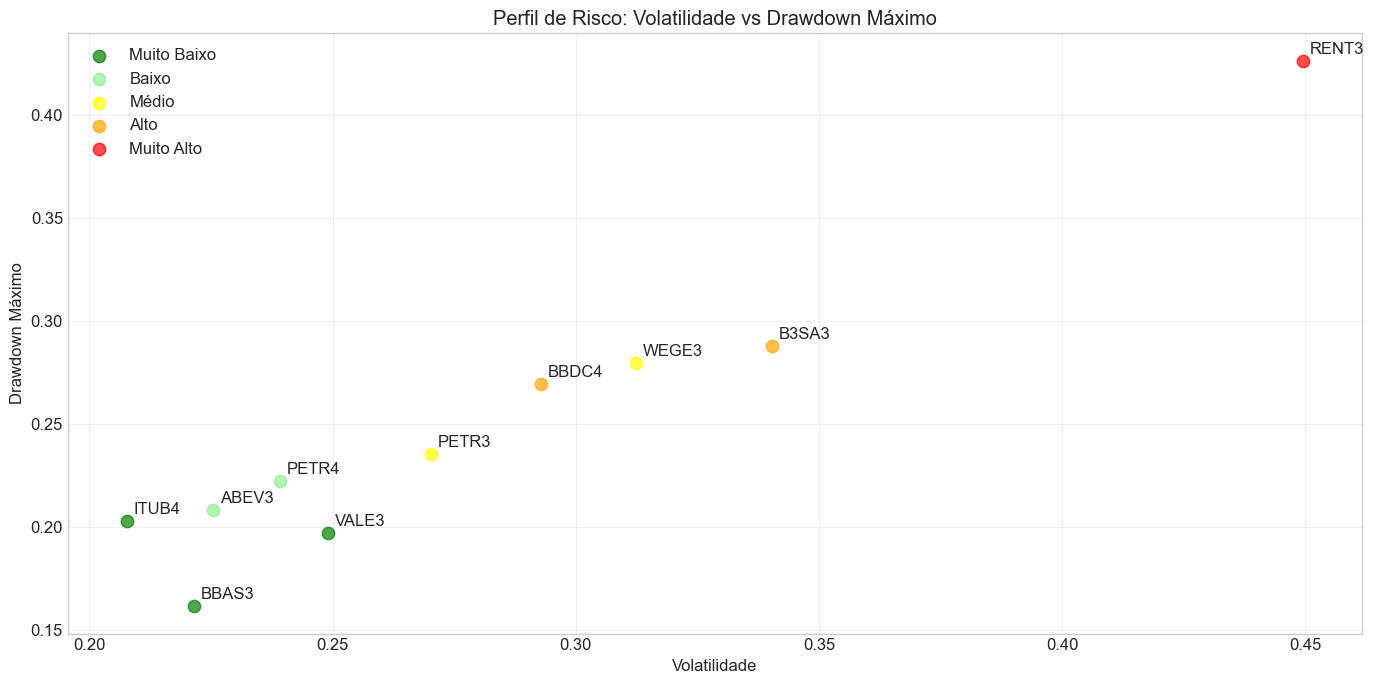

In [20]:
# Verificar se os dados foram gerados com sucesso
if not classified_stocks.empty:
    # Exibir as ações por nível de risco
    print("=" * 70)
    print("AÇÕES AGRUPADAS POR NÍVEL DE RISCO")
    print("=" * 70)
    
    risk_levels = sorted(classified_stocks['Risk_Level'].unique())
    
    for level in risk_levels:
        risk_description = classified_stocks[classified_stocks['Risk_Level'] == level]['Risk_Description'].iloc[0]
        stocks_in_level = classified_stocks[classified_stocks['Risk_Level'] == level]
        
        print(f"\nNível {level} - {risk_description} ({len(stocks_in_level)} ações):")
        
        for i, (_, stock) in enumerate(stocks_in_level.iterrows(), 1):
            print(f"  {i}. {stock['Ticker']} - Vol: {stock['Volatility']:.3f}, "
                  f"DD: {stock['Max_Drawdown']:.3f}, Beta: {stock['Beta']:.2f}")
    
    # Visualização das ações por nível de risco
    plt.figure(figsize=(14, 7))
    
    # Cores para cada nível de risco
    colors = {
        'Muito Baixo': 'green',
        'Baixo': 'lightgreen',
        'Médio': 'yellow',
        'Alto': 'orange',
        'Muito Alto': 'red'
    }
    
    # Gráfico de dispersão: Volatilidade vs Max Drawdown
    for risk in ['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto']:
        subset = classified_stocks[classified_stocks['Risk_Description'] == risk]
        if not subset.empty:
            plt.scatter(subset['Volatility'], subset['Max_Drawdown'], 
                      label=risk, color=colors[risk], s=80, alpha=0.7)
    
    # Adicionar rótulos dos tickers
    for i, row in classified_stocks.iterrows():
        plt.annotate(row['Ticker'], 
                   (row['Volatility'], row['Max_Drawdown']),
                   xytext=(5, 5), textcoords='offset points')
    
    plt.title('Perfil de Risco: Volatilidade vs Drawdown Máximo')
    plt.xlabel('Volatilidade')
    plt.ylabel('Drawdown Máximo')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Não foi possível gerar os dados de classificação de risco.")


## Conclusão  

Neste notebook, realizamos a classificação de risco das ações da B3 com base em:  

1. **Volatilidade**: Medida de variabilidade dos retornos  
2. **Drawdown Máximo**: Maior queda percentual no período analisado  
3. **Beta**: Sensibilidade do ativo em relação ao mercado (IBOVESPA)  
4. **Liquidez**: Volume médio diário de negociação  

As ações foram classificadas em 5 níveis de risco:  
- Nível 1: Muito Baixo  
- Nível 2: Baixo  
- Nível 3: Médio  
- Nível 4: Alto  
- Nível 5: Muito Alto  

Os dados gerados foram salvos em arquivos CSV no diretório configurado e podem ser utilizados para integração com sistemas de recomendação e análise de investimentos.  